In [1]:
import Pkg; Pkg.add("PyPlot"); Pkg.add("ForwardDiff"); Pkg.activate(@__DIR__); Pkg.instantiate()

In [2]:
using LinearAlgebra
using PyPlot
using ForwardDiff
using RobotZoo
using RobotDynamics
using MatrixCalculus

In [3]:
#Acrobot Dynamics
a = RobotZoo.Acrobot()
h = 0.05

# Parameters of the tractor-trailer
# g_velocity = 0.1
g_tractor_wheelbase = 3.0
g_tractor_hitch_offset = 0.5
g_trailer_wheelbase = 6.0
max_alpha = atan(g_tractor_wheelbase/sqrt((g_trailer_wheelbase^2) - (g_tractor_hitch_offset^2)))

function tractor_trailer_qdot(q_current,u)
    
    # Variable to store the rate of change of state
    alpha = u[1]
    gear = 1
    g_velocity = u[2]
    
    if(alpha!=0)
        r1 = g_tractor_wheelbase/tan(alpha);
        psi = -1*(alpha/abs(alpha))*atan(g_tractor_hitch_offset/abs(r1));
        va = (gear*g_velocity/abs(g_velocity))*abs(((gear*g_velocity*g_tractor_hitch_offset*tan(alpha))/(g_tractor_wheelbase*sin(psi))));
        vb = va*abs(cos(psi-q_current[4]));
        r2 = g_tractor_hitch_offset/sin(psi);
        r3 = g_trailer_wheelbase/sin(psi-q_current[4]);
        omega_1 = gear*g_velocity*(1/r1);
        omega_2 = gear*g_velocity*((r2)/(r1*r3));
        trailer_theta_dot = omega_2;
        beta_dot = gear*g_velocity*(((r2)/(r1*r3)) - (1/r1));
    end

    # Special case when alpha equals zero
    if(alpha==0)
        va = gear*g_velocity;
        psi = 0;
        phi = (pi/2) - (abs(q_current[4]) - (pi/2));
        hitch_turn_radius_zero_alpha = g_trailer_wheelbase/sin(phi);
        trailer_theta_dot = va/hitch_turn_radius_zero_alpha;
        beta_dot = trailer_theta_dot;
        vb = va*abs(cos(psi-q_current[4]));

        if(sin(phi)==0)
            beta_dot = 0;
            trailer_theta_dot = 0;
        end
        
    end
    

    q_dot = [vb*cos(q_current[3]); vb*sin(q_current[3]); trailer_theta_dot; beta_dot]

    return q_dot;
end

tractor_trailer_qdot (generic function with 1 method)

In [4]:
function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = tractor_trailer_qdot(x, u)
    f2 = tractor_trailer_qdot(x + 0.5*h*f1, u)
    f3 = tractor_trailer_qdot(x + 0.5*h*f2, u)
    f4 = tractor_trailer_qdot(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [5]:
function dfdx(x,u)
    ForwardDiff.jacobian(dx->dynamics_rk4(dx,u),x)
end

function dfdu(x,u)
    ForwardDiff.jacobian(du->dynamics_rk4(x,du),u)
end

dfdu (generic function with 1 method)

In [17]:
Nx = 4     # number of state
Nu = 2     # number of controls
Tfinal = 13.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [18]:
# Cost weights
Q = Diagonal([1.0*ones(2); 0.1*ones(2)]);
R = Diagonal(1*ones(2));
Qn = Array(100.0*I(Nx));

In [19]:
function stage_cost(x,u)
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5*u'*R*u
end

stage_cost (generic function with 1 method)

In [20]:
function terminal_cost(x)
    return 0.5*(x-xgoal)'*Qn*(x-xgoal)
end

terminal_cost (generic function with 1 method)

In [21]:
function cost(xtraj,utraj)
    J = 0.0
    for k = 1:(Nt-1)
        J += stage_cost(xtraj[:,k],utraj[:,k])
    end
    J += terminal_cost(xtraj[:,Nt])
    return J
end

cost (generic function with 1 method)

In [22]:
#Initial guess
x0 = [0; 0; pi/2; pi]
u0 = [-0.2;0.5]
xgoal = [5; 0; pi/2; pi]
xtraj = kron(ones(1,Nt), x0)
utraj = kron(ones(1,Nt-1), u0) #randn(Nt-1);
# println("Size of utraj: ", size(utraj))

2×260 Matrix{Float64}:
 -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  …  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2
  0.5   0.5   0.5   0.5   0.5   0.5      0.5   0.5   0.5   0.5   0.5   0.5

In [23]:
#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[:,k])
end
J = cost(xtraj,utraj)

8143.601830727934

In [24]:
#DDP Algorithm
p = zeros(Nx,Nt)
P = zeros(Nx,Nx,Nt)
d = ones(2,Nt-1)
K = zeros(Nu,Nx,Nt-1)
ΔJ = 0.0

xn = zeros(Nx,Nt)
# un = zeros(Nt-1)
un = zeros(Nu, Nt-1)


gx = zeros(Nx)
gu = zeros(Nu)
Gxx = zeros(Nx,Nx)
Guu = zeros(Nu,Nu)
Gxu = zeros(Nx)
Gux = zeros(Nx)

println("max of d before: ", maximum(abs.(d[:,:])))


iter = 0
while maximum(abs.(d[:,:])) > 1e-3
    iter += 1
    
    p = zeros(Nx,Nt)
    P = zeros(Nx,Nx,Nt)
    d = ones(2,Nt-1)
    K = zeros(Nu,Nx,Nt-1)
    ΔJ = 0.0

    p[:,Nt] = Qn*(xtraj[:,Nt]-xgoal)
#     println("Shape of p: ", size(p[:,Nt]))
    P[:,:,Nt] = Qn
    
    #Backward Pass
    for k = (Nt-1):-1:1
        #Calculate derivatives
        q = Q*(xtraj[:,k]-xgoal)
        r = R*utraj[:,k]
    
        A = dfdx(xtraj[:,k], utraj[:,k]) #ForwardDiff.jacobian(dx->dynamics_rk4(dx,utraj[k]),xtraj[:,k])
        B = dfdu(xtraj[:,k], utraj[:,k]) #ForwardDiff.derivative(du->dynamics_rk4(xtraj[:,k],du),utraj[k])
        
#         println("Value of B[1] is: ", B[1])
    
        gx = q + A'*p[:,k+1]
        gu = r + B'*p[:,k+1]
    
        Gxx = Q + A'*P[:,:,k+1]*A 
        Guu = R + B'*P[:,:,k+1]*B 
        Gxu = A'*P[:,:,k+1]*B 
        Gux = B'*P[:,:,k+1]*A
        
        d[:,k] = Guu\gu
        K[:,:,k] .= Guu\Gux
        
#         println("Size of K: ", size(K[:,:,k]))
#         tempro = gx - K[:,:,k]'*gu + K[:,:,k]'*Guu*d[:,k] - Gxu*d[:,k]
#         println("shape of tempro: ", size(tempro))
    
#         p[:,k] .= dropdims(gx - K[:,:,k]'*gu + K[:,:,k]'*Guu*d[:,k] - Gxu*d[:,k], dims=2)
        p[:,k] .= gx - K[:,:,k]'*gu + K[:,:,k]'*Guu*d[:,k] - Gxu*d[:,k]
        
        P[:,:,k] .= Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
    
        ΔJ += gu'*d[:,k]
    end

    #Forward rollout with line search
    xn[:,1] = xtraj[:,1]
    α = 1.0

    for k = 1:(Nt-1)
        un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k]*(xn[:,k]-xtraj[:,k])
        xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
    end
    
    Jn = cost(xn,un)
    
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α = 0.5*α
        for k = 1:(Nt-1)
            un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k]*(xn[:,k]-xtraj[:,k])
            xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
        end
        Jn = cost(xn,un)
    end
    #display(α)
    
    println("max of d: ", maximum(abs.(d[:,:])))
    
    println("Cost: ", Jn)
    
    J = Jn
    xtraj .= xn
    utraj .= un
end

max of d before: 1.0
max of d: 22.570948346346395
Cost: 6694.235373319123
max of d: 7.277074989702151
Cost: 4819.894217416253
max of d: 10.078295318139249
Cost: 4606.9056153106885
max of d: 3.841239859409888
Cost: 4564.995019553476
max of d: 10.759032736724675
Cost: 4526.281020690415
max of d: 6.116670135480222
Cost: 4336.934592879699
max of d: 8.034489238833528
Cost: 4331.640813049552
max of d: 7.949447594320294
Cost: 4309.545256612808
max of d: 6.8884911620571225
Cost: 4269.48633087894
max of d: 7.387875773948518
Cost: 4223.437437539566
max of d: 7.455428791637455
Cost: 4217.331444060949
max of d: 7.351596542308794
Cost: 4211.957214272269
max of d: 7.326648420277275
Cost: 4211.703162336572
max of d: 7.682356681505827
Cost: 4206.566687940934
max of d: 8.382897451655785
Cost: 4199.452332527464
max of d: 9.660296996775404
Cost: 4191.196141979605
max of d: 11.638021736786037
Cost: 4131.661707283928
max of d: 7.930930303097032
Cost: 4051.42024989432
max of d: 10.575587864991926
Cost: 4033

LoadError: SingularException(2)

In [25]:
iter

46

In [26]:
J

3507.5379103174178

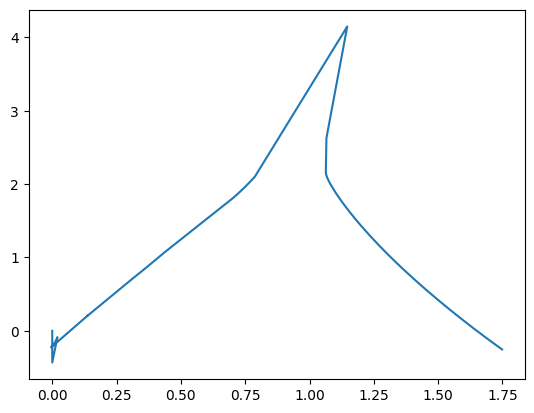

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2fcac822c0>

In [27]:
plot(xtraj[1,:],xtraj[2,:])

# plot(thist,xtraj[2,:])

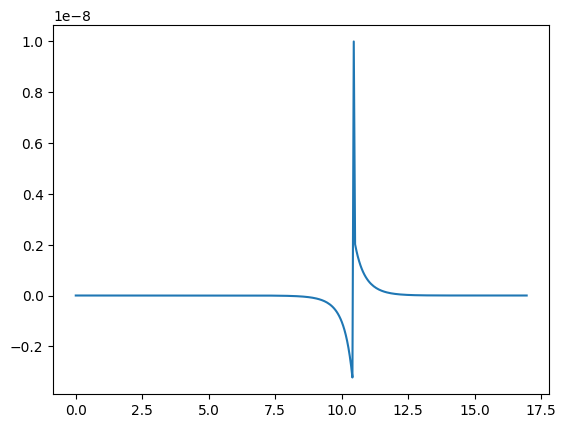

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f81432e5ea0>

In [81]:
plot(thist[1:Nt-1],utraj[1,:])

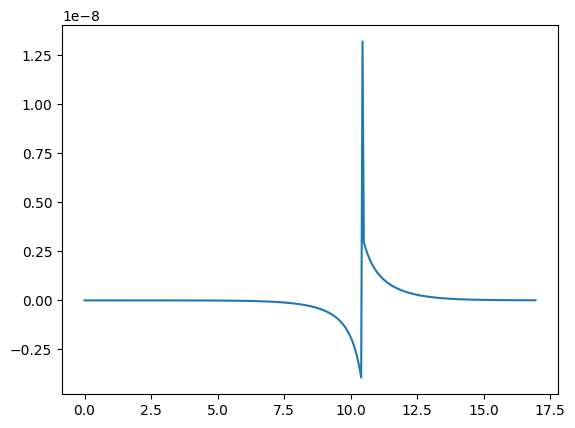

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8143156830>

In [82]:
plot(thist[1:Nt-1],utraj[2,:])

In [ ]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

In [ ]:
TrajOptPlots.set_mesh!(vis, a)

In [ ]:
X1 = [SVector{4}(x) for x in eachcol(xtraj)];
visualize!(vis, a, thist[end], X1)